In [1]:
import pandas as pd

#mail_df = pd.read_csv("../data/emails.csv", sep=";", nrows=10000)
mail_df = pd.read_csv("../data/emails.csv", sep=";")
mail_df = mail_df.drop(["cc"], axis=1)
mail_df = mail_df.rename(columns={"from": "from_"})
mail_df.drop(mail_df.query("from_ == '' | to == '' | subject == '' | date == '' | body == ''").index, inplace=True)
mail_df.head()


,from_,to,subject,date,body
0,monique.sanchez@enron.com,"sanchez@enron.com, ksanchez@houstonisd.org",RE: Response requested,"Wed, 2 May 2001 16:28:00 -0700 (PDT)",just Associate.....at Enron Wholesale Services...
1,monique.sanchez@enron.com,scottatlas@yahoo.com,RE: Reminder,"Wed, 10 Oct 2001 14:51:35 -0700 (PDT)",I would wear nice slacks and a nice shirt...ma...
2,monique.sanchez@enron.com,rosie.m.gonzalez@chase.com,RE: testing,"Wed, 23 May 2001 12:40:57 -0700 (PDT)",I'm glad you remembered my email. Glad to see...
3,monique.sanchez@enron.com,joseph.f.reid@accenture.com,Re: you can't hide...,"Mon, 14 May 2001 14:53:00 -0700 (PDT)","Hey there,\n\nDid you call me at the Derby? I..."
4,monique.sanchez@enron.com,moshuffle@hotmail.com,FW: Tuesday's P/L,"Wed, 30 May 2001 06:49:31 -0700 (PDT)","\n\n -----Original Message-----\nFrom: \tBike,..."


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np


my_stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                         'forwarded', 'corp', 'said', 'attached', 'ect',\
                                         'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                         'enronxgate', 'na', 'year'])

#vect = TfidfVectorizer(stop_words=my_stopwords, max_df=0.50, min_df=2)
cv = CountVectorizer(analyzer='word', stop_words=my_stopwords, max_features=2000)


X = cv.fit_transform(mail_df.body)

X_dense = X.todense()
#coords = PCA(n_components=2).fit_transform(X_dense)
#plt.scatter(coords[:, 0], coords[:, 1], c='m')
#plt.show()

In [7]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = cv.get_feature_names_out()
print(top_feats_in_doc(X, features, 1, 10))


   features  score
0     yahoo      8
1     scott      5
2  intended      4
3   sanchez      3
4      nice      3
5    friday      3
6   monique      3
7  reminder      3
8        09      2
9       use      2


/home/becode2/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[-23756477.403699998, -17306324.643064737, -12312664.414879732, -11086922.671808444, -10092369.738580205, -9396301.911490986]


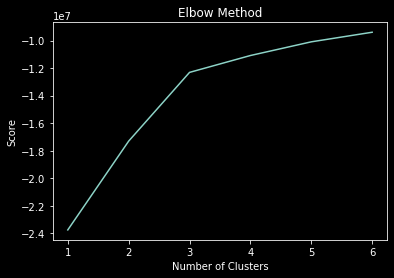

In [14]:
# Elbow method:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
print(score)

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

/home/becode2/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


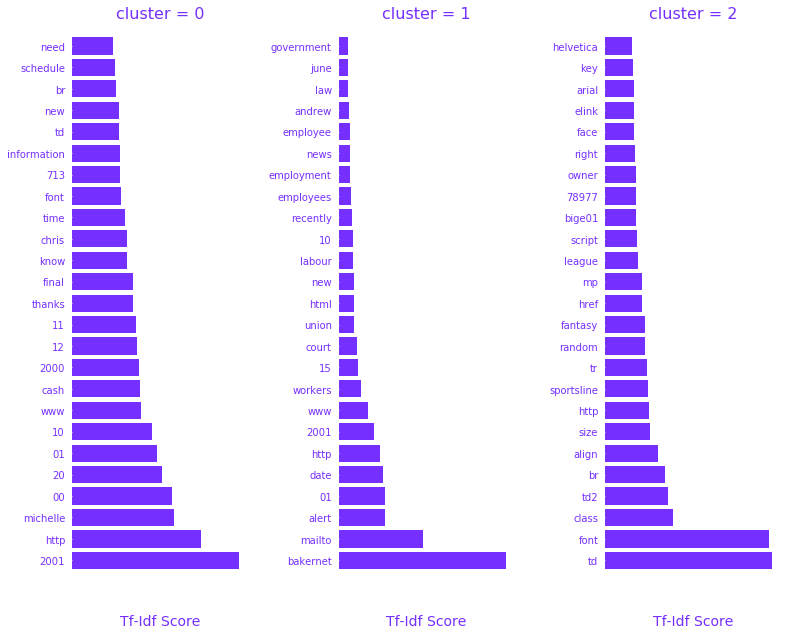

In [12]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

# pca = PCA(n_components=2).fit(X_dense)
centroids = clf.cluster_centers_
# centroid_coords = pca.transform(centroids)


def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs



def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14, color='#7530FF')
        ax.set_title("cluster = " + str(df.label), fontsize=16, color='#7530FF')
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features, color='#7530FF')
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


